<a href="https://colab.research.google.com/github/asgutierrt/Introduction-to-IA/blob/main/neural_networks/autoencoder_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# funciones

## auxiliary functions

In [43]:
# requerimientos
import os
import numpy as np
from sympy import *
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import json

################## support functions
def process_exp (model_label,model,local_grads,avrg_error,grad_dead_at,n,m,L,start,X_test,Y_d_test,dfs,csv_path):
  # unpack storage dfs
  predictions,w_vals,energia_error,error,deltas,avrg_delta = dfs

  # guardar informacion del entrenamiento
  for layer,ws in model.w_dict.items(): w_vals.at[model_label,layer]=str(ws.tolist())
  w_vals.to_csv(csv_path+"/w_vals.csv")

  # energia error
  df_error=pd.DataFrame(avrg_error,columns=pd.MultiIndex.from_tuples([('error',)+model_label]),dtype=float)
  energia_error=pd.concat([energia_error,df_error], axis=1)
  energia_error.to_csv(csv_path+"/energia_errores.csv")

  # error en entrenamiento
  error.loc[model_label,'train error']=df_error.mean().values[0]

  # error en test
  model.frwd_eval(model.w_dict,X_test.T)
  Y_pred=model.Y
  test_errors=np.mean(np.apply_along_axis(lambda x: np.matmul(x,x)/2, 1, Y_d_test-Y_pred.T))
  # guardar salidas prediccion
  Y_pred_dict=dict(zip(range(m),model.Y))
  for output,y_pred in Y_pred_dict.items(): predictions.at[model_label,output]=str(y_pred.tolist())
  predictions.to_csv(csv_path+"/predictions.csv")
  error.loc[model_label,'test error']=test_errors

  # execution time
  error.loc[model_label,'time [s]']=time.time()-start

  # local gradients
  cols_label=lambda layer, neurons: pd.MultiIndex.from_tuples([("$\\delta_%s$"%layer,)+model_label+('neuron %i'%i,) for i in neurons])
  info_delta=lambda grad_info,layer: pd.DataFrame(grad_info,dtype=float,columns=cols_label(layer,range(len(grad_info[0]))))
  df_local_grads=pd.concat([info_delta(local_grads[layer],layer) for layer in pd.DataFrame(local_grads)],axis=1)
  #deltas[df_local_grads.columns]=df_local_grads
  #deltas.to_csv(csv_path+"/deltas.csv")

  # mean local gradients
  df_mean=df_local_grads.groupby(level=[0,1,2,3],axis=1).mean()
  avrg_delta[df_mean.columns]=df_mean
  avrg_delta.to_csv(csv_path+"/avrg_deltas.csv")

  # estabilization values
  df_stable_mean=df_local_grads.iloc[grad_dead_at:].groupby(level=[0],axis=1).mean()
  error.loc[model_label,df_stable_mean.columns]=df_stable_mean.mean(axis=0)[df_stable_mean.columns]
  error.loc[model_label,'gradient death i']=grad_dead_at
  error.to_csv(csv_path+"/errores_train_test.csv")

  return predictions,w_vals,energia_error,error,deltas,avrg_delta

def graficar_df(df,layout,y_label,x_label,title,rot=0,figsize=(7,4),name='',path=''):
  dim_names=set(df.columns.get_level_values(0))
  fig_x,fig_y= (1,len(dim_names)) if layout=="h" else (len(dim_names),1)
  fig, ax = plt.subplots(fig_x,fig_y,figsize=figsize,sharex=True,squeeze=False)
  labels=None
  for i, (dimension, df_) in enumerate(df.groupby(level=0,axis=1)):
    ix,iy= (0,i) if layout=="h" else (i,0)
    labels_i=df_[dimension].columns.tolist()
    df_.plot(ax=ax[ix,iy],style=[".-"]*len(labels_i),rot=rot,legend=False)
    ax[ix,iy].set_ylabel(y_label(i))
    ax[ix,iy].set_xlabel(x_label)
    if labels is None: labels=labels_i
  fig.suptitle(title,y=1)
  fig.legend(labels,bbox_to_anchor=[0.5, 0.97],loc='upper center',ncol=12,fontsize="small",alignment='left')
  fig.tight_layout(); plt.savefig(path+'/%s.png'%name)

def graficar_Y(Y,predictions,figs,model_names,title,fig_path):
    fig = plt.figure(figsize=(8,5))
    cmap = plt.get_cmap('rainbow', 3)
    plt.plot(Y)
    style_list=["--","..",".-"]
    for i, name in enumerate(model_names):
        plt.gca().set_prop_cycle(None)
        Y_pred=np.array([json.loads(y_pred) for output,y_pred in predictions.loc[name].items()])
        plt.plot(Y_pred.T,linestyle=style_list[i])
    fig.legend(['Y%i'%i for i in range(Y.shape[1])]+["Y%i: "%i+model+" "+str(name) for model,name in zip(figs,model_names) for i in range(Y.shape[1])],
            bbox_to_anchor=[0.98, 0.899],loc='upper right')
    fig.suptitle(title);fig.tight_layout();plt.savefig(fig_path)

def load_data(data_path,fig_path=False,autoencoder=False):
    File_data = pd.read_csv(data_path, sep=",", header=None)
    File_data = 2*(File_data/np.max(File_data,axis=0))-1 # normalizar a [-1,1]

    # muestrear
    n_data,n_dim=File_data.shape
    ix=np.random.choice(n_data, n_data, replace=False)
    n_train=int(n_data*0.6); n_test=int(n_data*0.2); n_val=int(n_data*0.2)

    # sort data
    col_x,col_y=([0,1,2],[3,4]) if not autoencoder else ([0,1,2],[0,1,2])
    data_train=File_data[set(col_x+col_y)].loc[ix[:n_train]]
    data_test=File_data[set(col_x+col_y)].loc[ix[n_train:n_train+n_test]].sort_index()
    data_val=File_data[set(col_x+col_y)].loc[ix[-n_val:]].sort_index()

    # split data
    X = data_train[col_x].to_numpy(); Y_d = data_train[col_y].to_numpy()
    X_test=data_test[col_x].to_numpy(); Y_d_test = data_test[col_y].to_numpy()
    X_val=data_val[col_x].to_numpy(); Y_d_val = data_val[col_y].to_numpy()

    # plot
    fig, ax=plt.subplots(figsize=(12,5))
    data_train.sort_index().plot(style='.',markersize=0.5,color='y',ax=ax)
    data_test.plot(style='.',markersize=0.5,color='g',ax=ax)
    data_val.plot(style='.',markersize=0.5,color='r',ax=ax)

    # format figure
    if not autoencoder:
      vars=[("x%i"%x,x) for x in col_x]+[("y%i"%(y-len(col_x)),y) for y in col_y]
    else:
      vars=[("x%i/y%i"%(x,x),x) for x in col_x]
    annotate=data_test.iloc[-1]
    for x,ix in vars: ax.annotate(x,(annotate.name,annotate[ix]))

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::int(len(labels)/n_dim)], ['train','test','validation'])
    plt.savefig(fig_path+'/data.png')
    return X,Y_d,X_test,Y_d_test,X_val,Y_d_val

## mlp functions

In [8]:
class MLP:
  __slots__ = ['conf','w_dict','Y']
  def __init__(self,layers_setup,entrada,bias):
    self.conf={}; self.w_dict={};
    for layer,(neuronas,phi,diff_phi) in enumerate(layers_setup):
      self.conf[layer]=layer_obj(entrada,neuronas,phi,diff_phi,bias[layer])
      entrada=self.conf[layer].Y
      # save initial w values
      self.w_dict[layer]=self.conf[layer].W
    self.Y=entrada

  def frwd_eval(self,w_dict,entrada):
    for layer in range(len(self.conf)):
      self.conf[layer].update_w(w_dict[layer],entrada)
      entrada=self.conf[layer].Y
    self.Y=entrada

  def w_dict_update(self,layer,grad):
    self.w_dict[layer]+=grad

class layer_obj:
  __slots__ = ['m','phi','diff_phi','bias','x','W','V','Y','dY_dV']
  def __init__(self,x,m,phi,diff_phi,bias):
    # parametros estaticos
    self.m=m; self.phi=phi; self.diff_phi=diff_phi; self.bias=bias
    # initialize parameters
    np.random.seed(10)
    self.x=x
    self.W=np.random.rand(m,int(self.x.shape[0]))  # inicializar variables w para la capa
    # evaluate layer elements
    self.frwd_eval()

  def frwd_eval(self):
    # campo local inducido en cada perceptron
    self.V = np.matmul(self.W,self.x)
    self.V += np.ones((self.V.shape[0],self.V.shape[1]))*self.bias
    # funcion de activacion evaluada en el campo de los m perceptrones
    k=1
    self.Y=self.phi(self.V,k)
    # derivada de la funcion de activacion evaluada en el campo
    self.dY_dV=self.diff_phi(self.V,k)

  def update_w(self,w_vals,entrada):
    self.W=w_vals; self.x=entrada
    self.frwd_eval()

In [9]:
def grad_descent(X,Y_d,model,epocas=5,eta=1,tol=0):
  # orden para backpropagation
  layers_labels=sorted(model.conf.keys(),reverse=True)

  # almacenar informacion de cada iteracion
  local_grads={layer:[] for layer in layers_labels}

  avrg_error=[]
  grad_dead_at=None


  # batch vs. sequential
  seq=False
  pattern=lambda p: X[[p]].T if seq else X.T
  output=lambda p: Y_d[p] if seq else Y_d
  n_iteration=len(X)*epocas if seq else epocas
  window_size=len(X)*0.1 if seq else epocas*0.1

  # create progress bar
  pbar = tqdm(total=n_iteration*len(layers_labels))

  # initiate iterations
  iteracion=0;
  while iteracion < n_iteration:
    # forward model on point p
    p=iteracion%len(X); model.frwd_eval(model.w_dict,pattern(p))
    iteracion+=1

    # calculate gradients
    init_local_grad=None
    for layer in layers_labels:
      if init_local_grad is None:
        # local grad in output layer multiplies error
        error=output(p)-model.Y.T
        energia_error=np.apply_along_axis(lambda x: np.matmul(x,x)/2, 1, error)
        idx_p=energia_error.argmax()
        avrg_error.append(np.mean(energia_error,axis=0,keepdims=True))
        init_local_grad=-1*np.mean(error,axis=0).reshape((-1,1))

      # backward evaluation on point p
      local_grad = np.multiply(model.conf[layer].dY_dV[:,[idx_p]],init_local_grad)
      dJ_dw=np.matmul(local_grad,model.conf[layer].x[:,[idx_p]].T)
      init_local_grad=np.matmul(model.conf[layer].W.T,local_grad)

      # update w vals in layer
      model.w_dict_update(layer,eta*dJ_dw)

      # save local gradients
      local_grads[layer].append(local_grad.flatten())
      pbar.update(1) # update progress bar

    # guardar en que iteracion muere el gradiente
    last_grads_tol=lambda grads,window,: np.absolute(np.diff(np.array(grads[-int(window):]),n=1,axis=0))<tol
    if grad_dead_at is None and iteracion>window_size and all([last_grads_tol(local_grads[layer],window_size).all() for layer in layers_labels]):
      grad_dead_at=iteracion

    # detenerse despues de la ventana de evaluacion
    if grad_dead_at and iteracion>grad_dead_at+window_size:
      pbar.close()
      print("gradients died first at iteration %i"%grad_dead_at)
      break

  pbar.close()
  return local_grads, avrg_error, grad_dead_at

# cargar datos

In [10]:
!git clone https://github.com/asgutierrt/Introduction-to-IA.git

fatal: destination path 'Introduction-to-IA' already exists and is not an empty directory.


<ipython-input-43-2da172b45c4d>:101: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_train=File_data[set(col_x+col_y)].loc[ix[:n_train]]
<ipython-input-43-2da172b45c4d>:102: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_test=File_data[set(col_x+col_y)].loc[ix[n_train:n_train+n_test]].sort_index()
<ipython-input-43-2da172b45c4d>:103: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_val=File_data[set(col_x+col_y)].loc[ix[-n_val:]].sort_index()


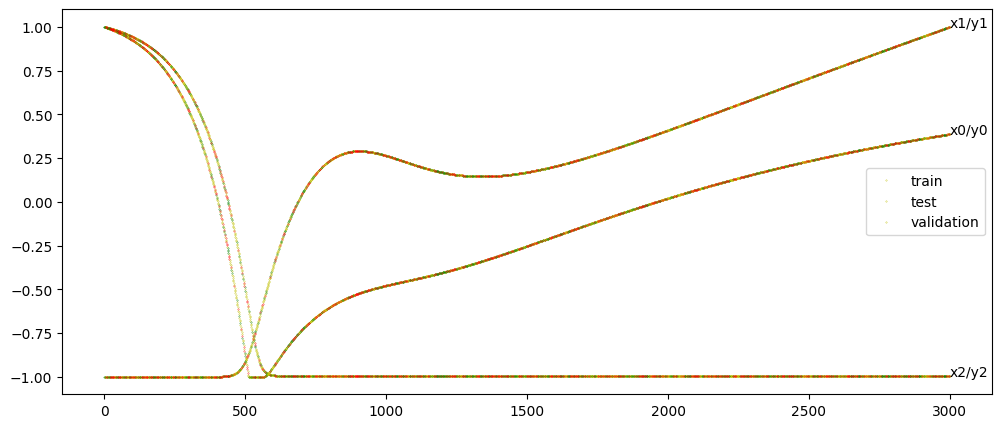

In [44]:
# paths para guardar resultados
fig_path = "figures"
csv_path = "resultados"
if not os.path.exists(fig_path): os.makedirs(fig_path)
if not os.path.exists(csv_path): os.makedirs(csv_path)

# cargar archivo
## load data
data_path='/content/Introduction-to-IA/neural_networks/mlp_data/bacterial_growth_extended.txt'
np.random.seed(2)
X,Y_d,X_test,Y_d_test,X_val,Y_d_val=load_data(data_path,fig_path,autoencoder=True)

# inicializar dfs para guardar resultados
model_label_info=['layers', 'neurons', 'eta']
error=pd.DataFrame(columns=model_label_info).set_index(model_label_info)
energia_error=pd.DataFrame();
my_index = pd.MultiIndex(levels=[[]]*5,codes=[[]]*5,names=['layer','L','li','eta','neuron'])
deltas=pd.DataFrame(index=[],columns=my_index)
avrg_delta=pd.DataFrame(index=[],columns=my_index.droplevel(-1))
predictions=pd.DataFrame(columns=model_label_info).set_index(model_label_info)
w_vals=pd.DataFrame(columns=model_label_info).set_index(model_label_info)
val_predictions=pd.DataFrame(columns=model_label_info).set_index(model_label_info)

In [12]:
import time
import copy

# activations
phi_t=lambda x,k: (np.exp(k*x)-np.exp(-k*x))/(np.exp(k*x)+np.exp(-k*x)) # tanh
diff_phi_t=lambda x,k: 1-phi_t(x,k)**2
phi_1=lambda x,k: k*x # lineal
diff_phi_1=lambda x,k: np.ones((x.shape[0],x.shape[1]))*k
phi_s=lambda x,k: 1/(1+exp(-k*x)) # sigmoide
diff_pfi_s=lambda x,k: k*exp(-k*x)/(1+exp(-k*x))**2

# entrenar MLP

In [45]:
# setup
L=1;mj=10
epocas=50; eta=0.9; tol=10**-3
bias=dict([(key,0) for key in range(L+1)])
layers_setup=lambda L,mj,m: [(mj,phi_t,diff_phi_t)]*L+[(m,phi_t,diff_phi_t)]

# run exp
start=time.time()
n=len(X[0]); m=len(Y_d[0])
dfs=[predictions,w_vals,energia_error,error,deltas,avrg_delta]

## init model
model_label=('L_tlt=%i'%L,'$l_i$=%i'%mj,'$eta=%.2f$'%eta)
model = MLP(layers_setup(L,mj,m),X.T,bias)# init model on random sol

## descenso por el gradiente
local_grads,avrg_errors,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)
# guardar informacion del entrenamiento
dfs=process_exp(model_label,model,local_grads,avrg_errors,grad_dead_at, n,m,L,start,X_test,Y_d_test,dfs,csv_path)
predictions,w_vals,energia_error,error,deltas,avrg_delta=dfs

  0%|          | 0/100 [00:00<?, ?it/s]

gradients died first at iteration 16


,,,train error,test error,time [s],$\delta_0$,$\delta_1$,gradient death i
layers,neurons,eta,,,,,,
L_tlt=1,$l_i$=10,$eta=0.90$,0.589814,0.398304,0.460787,-0.000409,0.000198,16.0


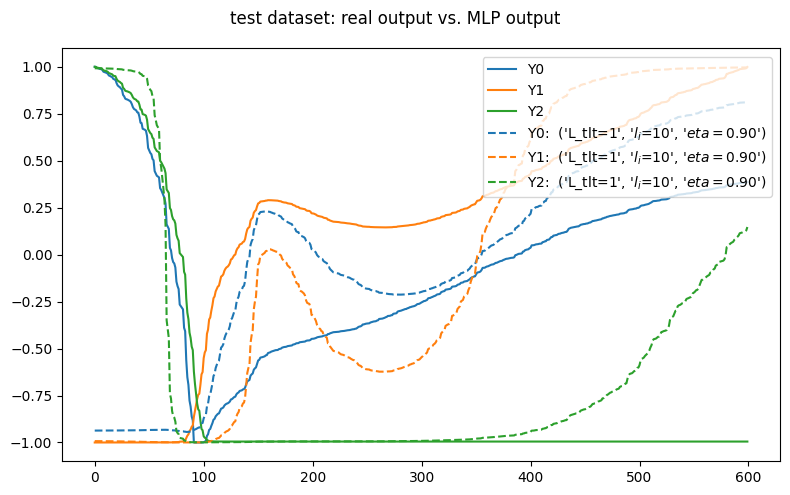

In [46]:
# plot all
model_names=error.index.to_list()
figs=['']*len(model_names)

## plot outputs
graficar_Y(Y_d_test,predictions,figs,model_names,
        "test dataset: real output vs. MLP output",fig_path+'/outputs.png')
## errors
display(error.loc[model_names].sort_index())

# correr experimentos para calibrar hyperparametros

In [ ]:
## experimentacion
epocas=100; tol=10**-3
n=len(X[0]); m=len(Y_d[0])
layers_setup=lambda L,mj,m: [(mj,phi_t,diff_phi_t)]*L+[(m,phi_t,diff_phi_t)]

dfs=[predictions,w_vals,energia_error,error,deltas,avrg_delta]

for L in [1]:
    bias=dict([(key,-0.3) for key in range(L)]+[(L,0)])
    for eta in [0.9,0.5,0.2]:
        exp_name="L=%i eta=%.2f"%(L,eta) # experiment identifier
        print('running ',exp_name)
        for mj in [1,2,4,5,6,7,8,9,10]:
            model_label=('L=%i'%L, '$l_i$=%i'%mj,'$eta=%.2f$'%eta)
            start=time.time()

            # initialize model
            model = MLP(layers_setup(L,mj,m),X.T,bias)# init model on random sol

            # descenso por el gradiente
            local_grads,avrg_error,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)

            # guardar informacion del entrenamiento
            dfs=process_exp(model_label,model, local_grads,avrg_error,grad_dead_at,n,m,L,start,X_test,Y_d_test,dfs,csv_path)

        # visualizaciones de cada experimento
        args_exp={'key':("L=%i"%L,'$eta=%.2f$'%eta), 'level':[1,3],'axis':1}
        avrg_delta=dfs[-1] # unpack avrg_delta
        graficar_df(avrg_delta.xs(**args_exp),'v',lambda i: "avrg $\\delta_%s$"%i,
                    'iteration (0-N*epochs)',"average local gradient progression - %s"%exp_name,
                    rot=0,figsize=(12,6),name='fig_avrg_delta_%s'%exp_name.replace(" ", "_"),path=fig_path)

# guardar resultados de cada experimento
predictions,w_vals,energia_error,error,deltas,avrg_delta=dfs

running  L=1 eta=0.90


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 38


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 32


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 26


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 39


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 31


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 12


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 18


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 25


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 16
running  L=1 eta=0.50


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 50


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 42


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 38


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 57


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 52


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 22


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 21


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 21


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 21
running  L=1 eta=0.20


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 80


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 79


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 66


  0%|          | 0/200 [00:00<?, ?it/s]

# visualizaciones adicionales

In [ ]:
## selection criteria
criteria=["train error"]
figs=['best mlp','worst mlp','avrg mlp']
error.sort_values(by=criteria, inplace=True)
model_names=[error[error[criteria]==error[criteria].min()].dropna(how='all').index[0],
            error[error[criteria]==error[criteria].max()].dropna(how='all').index[0],
            error[error[criteria] >= error[criteria].mean()].dropna(how='all').iloc[0].name]

# only best
criteria=["train error"]
figs=['best mlp']
model_names=[error[error[criteria]==error[criteria].min()].dropna(how='all').index[0]]

# plot all
#model_names=error.index.to_list(); figs=['']*len(model_names)

,,,train error,test error,time [s],$\delta_0$,$\delta_1$,gradient death i
layers,neurons,eta,,,,,,
L=1,$l_i$=4,$eta=0.90$,0.190079,0.124201,0.379523,-0.000455,0.000981,24.0


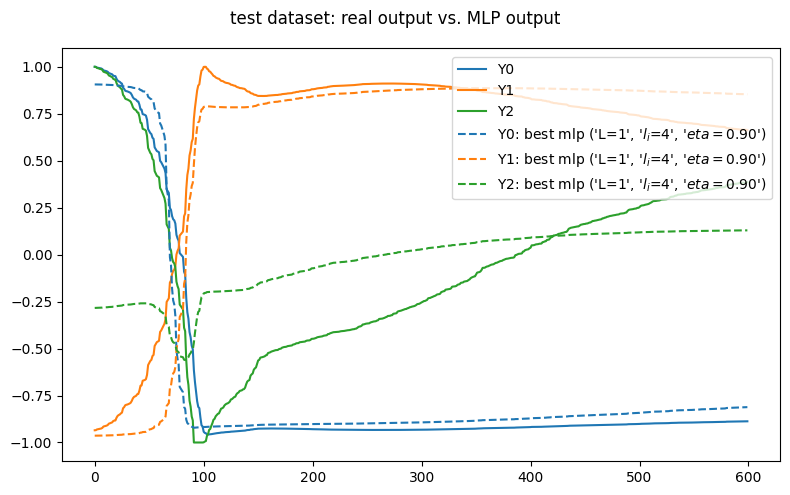

In [ ]:
## plot outputs
graficar_Y(Y_d_test,predictions,figs,model_names,
        "test dataset: real output vs. MLP output",fig_path+'/test_outputs.png')
## errors
display(error.loc[model_names].sort_index())

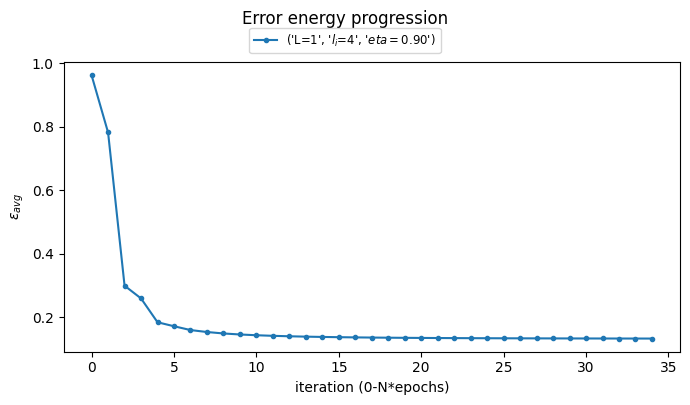

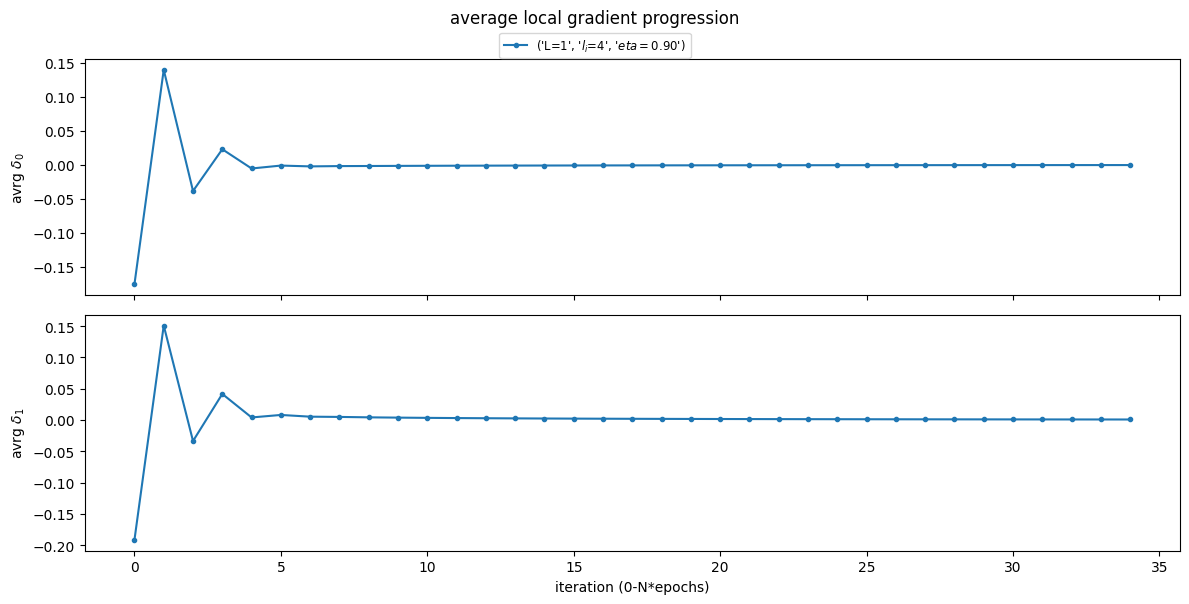

In [ ]:
## plot error energy
filter=[x[1:] in model_names for x in energia_error.columns]
graficar_df(energia_error.loc[:,filter],'v',lambda i: "$\\varepsilon_{avg}$",
            'iteration (0-N*epochs)',"Error energy progression",rot=0,
            name='error_energy',path=fig_path)
## plot avrg local gradients
filter=[x[1:] in model_names for x in avrg_delta.columns]
graficar_df(avrg_delta.loc[:,filter],'v',lambda i: "avrg $\\delta_%s$"%i,
            'iteration (0-N*epochs)',"average local gradient progression",
            rot=0,figsize=(12,6),name='avrg_delta',path=fig_path)

,,,train error,test error,time [s],$\delta_0$,$\delta_1$,gradient death i,val error
layers,neurons,eta,,,,,,,
L=1,$l_i$=4,$eta=0.90$,0.190079,0.124201,0.379523,-0.000455,0.000981,24.0,0.964824


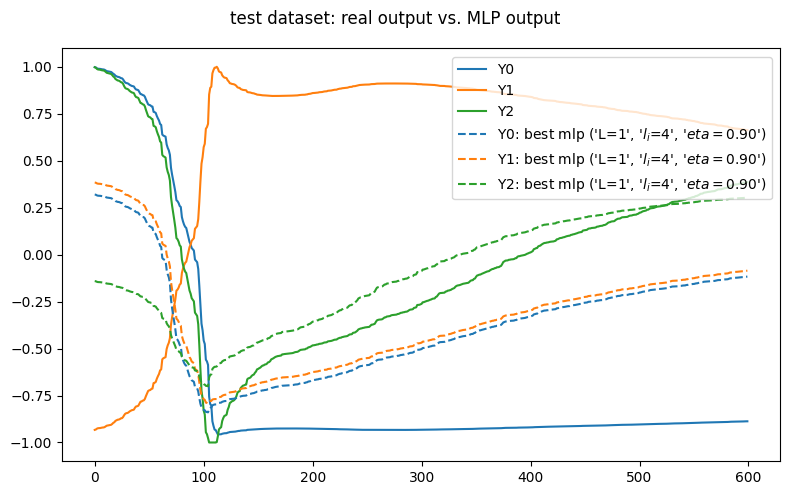

In [ ]:
import json

## validation error
for model_label in model_names:
  # init model on random W values
  L=int(model_label[0][-1]); mj=int(model_label[1][-1])
  model = MLP(layers_setup(L,mj,m),X_val.T,bias)

  # set W values to selected solution
  for layer,w in w_vals.loc[model_label].items():
    model.w_dict_update(layer,json.loads(w)-model.w_dict[layer])
  energia=np.apply_along_axis(lambda x: np.matmul(x,x)/2, 1, Y_d_val-model.Y.T)
  val_error=np.mean(energia,axis=0,keepdims=True)

  # save results
  error.loc[model_label,'val error']=val_error
  Y_pred_dict=dict(zip(range(m),model.Y))
  for output,y_pred in Y_pred_dict.items(): val_predictions.at[model_label,output]=str(y_pred.tolist())


## plot outputs
graficar_Y(Y_d_val,val_predictions,figs,model_names,
        "validation dataset: real output vs. MLP output",fig_path+'/val_outputs.png')
## errors
display(error.loc[model_names].sort_index())

# sklearn MLP

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


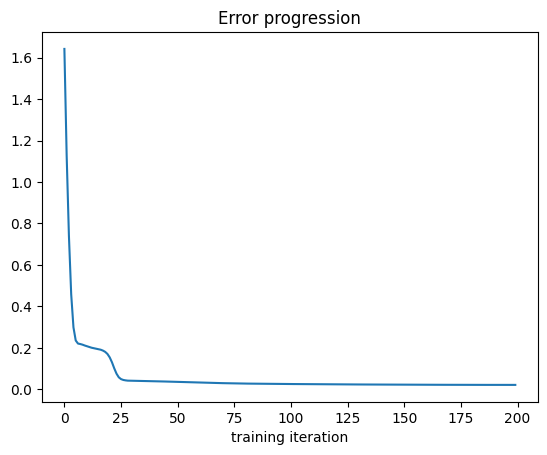

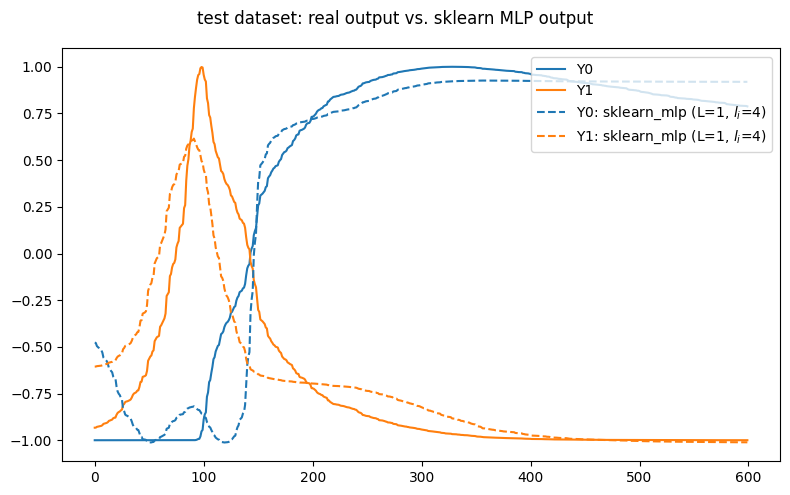

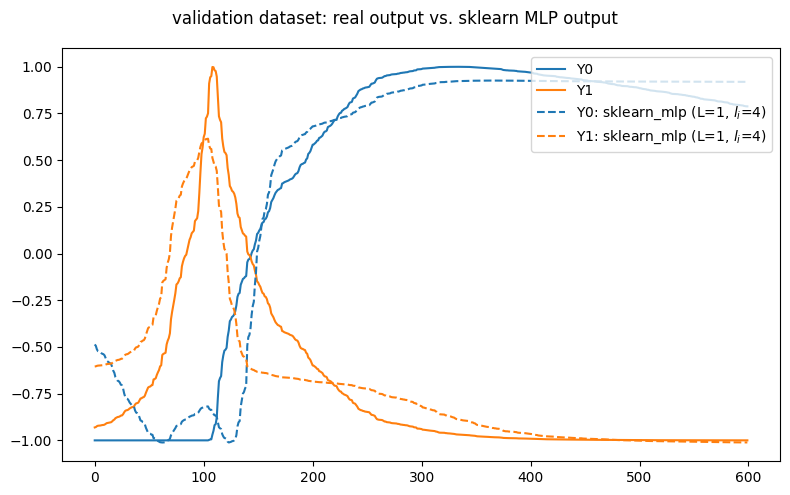

In [17]:
from sklearn.neural_network import MLPRegressor

L,mj=1,4

mlp_model = MLPRegressor(hidden_layer_sizes=(L,mj),activation='tanh',
                         learning_rate_init=0.01,early_stopping=True,
                         random_state=0)
# train MLP
mlp_model.fit(X, Y_d)
error=[np.sum((Y_d-mlp_model.predict(X))**2/2,axis=1)]

# training error
plt.plot(mlp_model.loss_curve_)
plt.xlabel('training iteration'); plt.title("Error progression")
plt.savefig(fig_path+'/sklearn_mlp_error')

# predict test data
Y_pred=mlp_model.predict(X_test)
error.append(np.sum((Y_d_test-Y_pred)**2/2,axis=1))
# plot test outputs
model_names=[''.join(('(L=%i, '%L,'$l_i$=%i)'%mj))]
predictions=pd.DataFrame([str(x.tolist()) for x in Y_pred.T],index=list(range(len(Y_pred[0]))),columns=model_names).T
figs=['sklearn_mlp']

graficar_Y(Y_d_test,predictions,figs,model_names,
        "test dataset: real output vs. sklearn MLP output",fig_path+'/sklearn_test_outputs.png')

# predict validation data
Y_pred=mlp_model.predict(X_val)
error.append(np.sum((Y_d_val-Y_pred)**2/2,axis=1))

# plot test outputs
model_names=[''.join(('(L=%i, '%L,'$l_i$=%i)'%mj))]
predictions=pd.DataFrame([str(x.tolist()) for x in Y_pred.T],index=list(range(len(Y_pred[0]))),columns=model_names).T
figs=['sklearn_mlp']

graficar_Y(Y_d_val,predictions,figs,model_names,
        "validation dataset: real output vs. sklearn MLP output",fig_path+'/sklearn_val_outputs.png')

In [ ]:
# R2 score
r2_error=[mlp_model.score(x, y)**2/2 for x,y in zip([X,X_test,X_val],[Y_d,Y_d_test,Y_d_val])]
# J error
J_error=[np.mean(x) for x in error]
pd.DataFrame(J_error,index=['train error','test_error','validation error'],columns=['sklearn_MLP '+model_names[0]]).T

,train error,test_error,validation error
"sklearn_MLP (L=1, $l_i$=4)",0.02137,0.019068,0.021197
